In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class Load_Dataset:
    def __init__(self, path):
        self.path = path

    def load_data(self):
        df = pd.read_csv(self.path)
        return df

In [4]:
file_name = "2025.06.16 1112 - dt-daily-usage.csv"

try:
    data_loader = Load_Dataset(file_name)
    df = data_loader.load_data()
    print("File Loaded succesfully")
    print(f"List of columns: {df.columns} ")
except FileNotFoundError as e:
    print(f"File: {file_name} not found error: {e}")

File Loaded succesfully
List of columns: Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount'], dtype='object') 


In [5]:
df['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'])

In [6]:
df.info()
print("Total Missing values in each column")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp (UTC)  8404 non-null   datetime64[ns, UTC]
 1   Meter Number     8404 non-null   int64              
 2   Usage Amount     8404 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 197.1 KB
Total Missing values in each column


Timestamp (UTC)    0
Meter Number       0
Usage Amount       0
dtype: int64

In [7]:
df['day_of_week'] = df['Timestamp (UTC)'].dt.day_name()
df['month'] = df['Timestamp (UTC)'].dt.month_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

print('\nDataset with New Columns')
df.columns


Dataset with New Columns


Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount', 'day_of_week',
       'month', 'is_weekend'],
      dtype='object')

# **Exploratory Data Analysis**

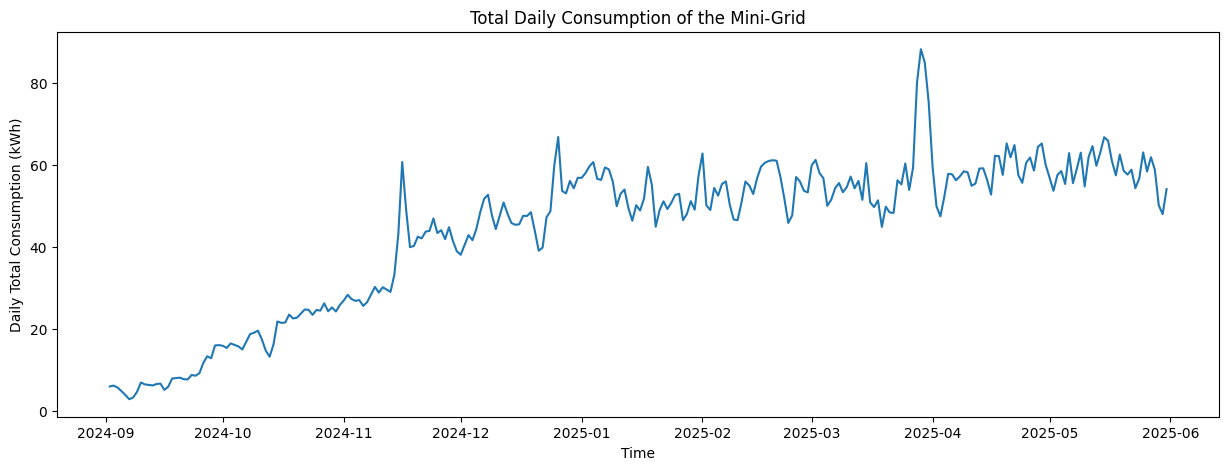

In [8]:
# Calculate total consumption per day

total_daily_consumption = df.groupby('Timestamp (UTC)')['Usage Amount'].sum().reset_index()

#Plot

plt.figure(figsize=(15,5))
sns.lineplot(data=total_daily_consumption, x='Timestamp (UTC)', y='Usage Amount')
plt.title('Total Daily Consumption of the Mini-Grid')
plt.xlabel('Time')
plt.ylabel('Daily Total Consumption (kWh)')
plt.show()

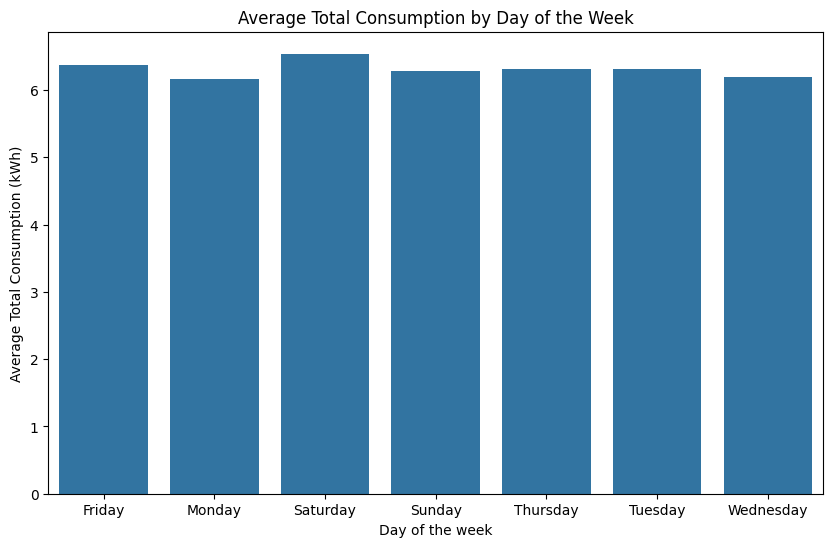

In [9]:
# Analyze comsumption by Day of the week

avg_comsumption_by_day = df.groupby('day_of_week')['Usage Amount'].sum()/df['Timestamp (UTC)'].nunique()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_comsumption_by_day.reindex(day_order)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_comsumption_by_day.index, y=avg_comsumption_by_day.values)
plt.title('Average Total Consumption by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Average Total Consumption (kWh)')
plt.show()

In [10]:
customer_metrics = df.groupby('Meter Number')['Usage Amount'].agg(
    avg_daily_kwh='mean',
    std_dev_kwh='std'
).reset_index()

weekend_consumption = df[df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()
weekday_consumption = df[~df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()

ratio_series = (weekend_consumption / weekday_consumption).fillna(1)

customer_metrics['weekend_weekday_ratio'] = customer_metrics['Meter Number'].map(ratio_series)

print("Customer Metrics")
customer_metrics.head(10)

Customer Metrics


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio
0,240000029134,1.084320,0.704037,1.049797
1,240000029159,0.872797,0.233724,1.026061
2,240000029167,0.232411,0.056976,1.041951
3,240000029175,0.917712,0.499405,1.067378
4,240000029191,1.134669,1.124506,0.811102
5,240000029209,1.130843,0.236863,0.990211
6,240000029571,0.854138,0.099499,0.995210
7,240000029589,0.436366,0.118659,1.010944
8,240000029605,4.672615,1.338896,1.032495
9,240000029894,5.290332,1.558374,1.042214


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = customer_metrics[['avg_daily_kwh','std_dev_kwh', 'weekend_weekday_ratio']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kMeans = KMeans(n_clusters=5, random_state=42, n_init=20)
customer_metrics['cluster'] = kMeans.fit_predict(features_scaled)
print("Cutomers with their assigned cluster")
customer_metrics.head()


Cutomers with their assigned cluster


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster
0,240000029134,1.084320,0.704037,1.049797,2
1,240000029159,0.872797,0.233724,1.026061,2
2,240000029167,0.232411,0.056976,1.041951,4
3,240000029175,0.917712,0.499405,1.067378,2
4,240000029191,1.134669,1.124506,0.811102,0


In [12]:
cluster_name_map = {
    3: 'Anchor Load',
    0: 'Power Household',
    2: 'Standard Household',
    4: 'Low Use / Business',
    1: 'Anomaly / Inactive'
}

customer_metrics['segment_name'] = customer_metrics['cluster'].map(cluster_name_map)

In [13]:
customer_metrics.head()

,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster,segment_name
0,240000029134,1.084320,0.704037,1.049797,2,Standard Household
1,240000029159,0.872797,0.233724,1.026061,2,Standard Household
2,240000029167,0.232411,0.056976,1.041951,4,Low Use / Business
3,240000029175,0.917712,0.499405,1.067378,2,Standard Household
4,240000029191,1.134669,1.124506,0.811102,0,Power Household


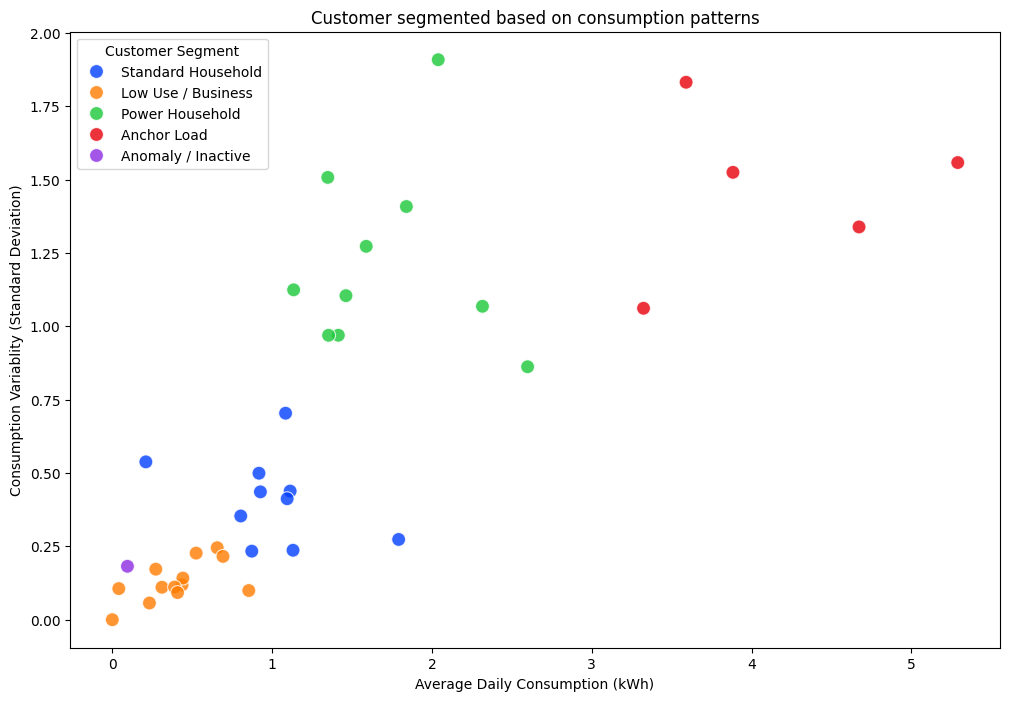

In [14]:
#visualize segments

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=customer_metrics,
    x='avg_daily_kwh',
    y='std_dev_kwh',
    hue='segment_name',
    palette="bright",
    s=100,
    alpha=0.8
)
plt.title('Customer segmented based on consumption patterns')
plt.xlabel('Average Daily Consumption (kWh)')
plt.ylabel('Consumption Variablity (Standard Deviation)')
plt.legend(title='Customer Segment')
plt.show()

In [15]:
cluster_summary = customer_metrics.groupby('cluster')[['avg_daily_kwh', 'std_dev_kwh', 'weekend_weekday_ratio']].mean()
# print(cluster_summary)

In [7]:
data_loader_hour = Load_Dataset("2025.06 (1).csv")
dfh = data_loader_hour.load_data()
dfh.shape

(142776, 3)

In [8]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M:%S')

print(dfh['Timestamp (UTC)'].head(10))

0    2024-10-15 09:00:00
1    2024-10-15 10:00:00
2    2024-10-15 11:00:00
3    2024-10-15 12:00:00
4    2024-10-15 13:00:00
5    2024-10-15 14:00:00
6    2024-10-15 15:00:00
7    2024-10-15 16:00:00
8    2024-10-15 17:00:00
9    2024-10-15 18:00:00
Name: Timestamp (UTC), dtype: object


In [9]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)']).dt.tz_localize(None)

In [10]:
dfh['Timestamp (UTC)']

0        2024-10-15 09:00:00
1        2024-10-15 10:00:00
2        2024-10-15 11:00:00
3        2024-10-15 12:00:00
4        2024-10-15 13:00:00
                 ...        
142771   2025-05-31 07:00:00
142772   2025-05-31 08:00:00
142773   2025-05-31 09:00:00
142774   2025-05-31 10:00:00
142775   2025-05-31 11:00:00
Name: Timestamp (UTC), Length: 142776, dtype: datetime64[ns]

In [11]:
len(dfh['Meter Number'].unique())

36

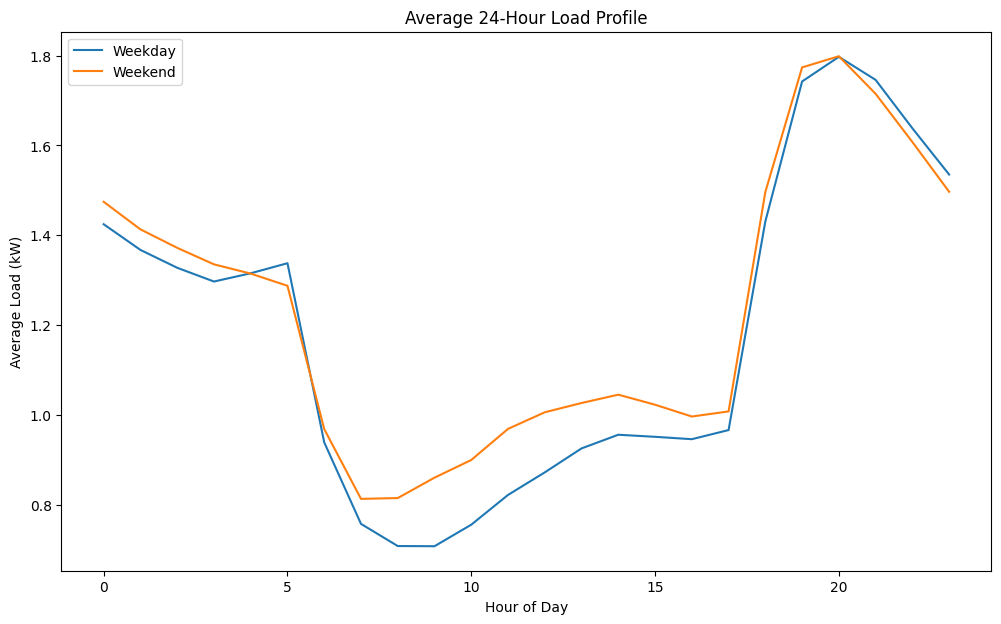

In [12]:
dfh['Hour'] = dfh['Timestamp (UTC)'].dt.hour
dfh['is_weekend'] = dfh['Timestamp (UTC)'].dt.dayofweek >= 5

total_hourly_load = dfh.groupby(['Timestamp (UTC)', 'Hour', 'is_weekend'])['Usage Amount'].sum().reset_index()

avg_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour'])['Usage Amount'].mean().unstack(level=0)
avg_load_profile.columns = ['Weekday', 'Weekend']

avg_load_profile.plot(figsize=(12,7), title='Average 24-Hour Load Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load (kW)')
plt.show()

C:\Users\EEK\AppData\Local\Temp\ipykernel_16624\3277826617.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)


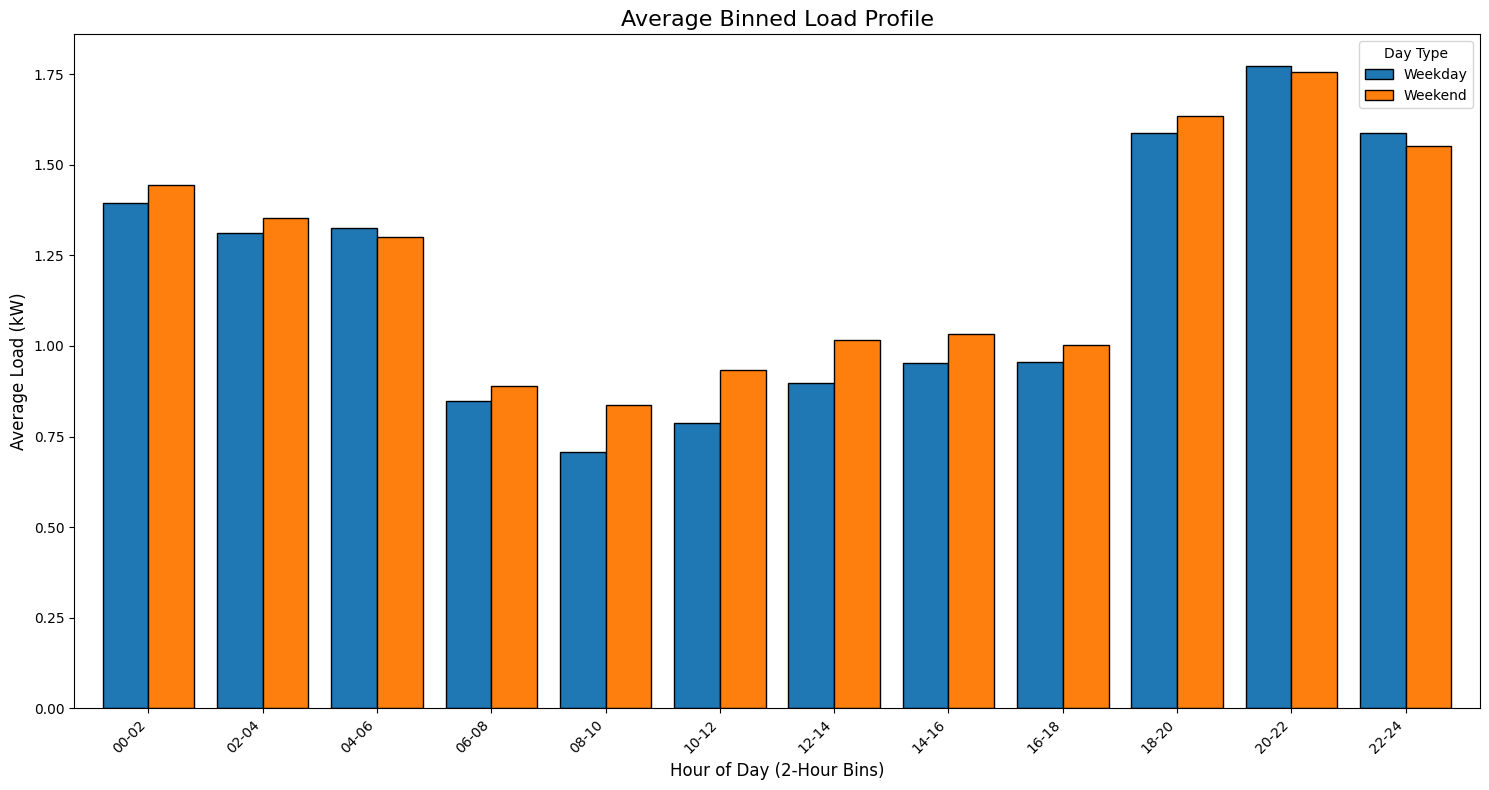

In [13]:
bins = range(0,25,2)
labels =[f"{i:02d}-{i+2:02d}" for i in bins[:-1]]

total_hourly_load['Hour_bin'] = pd.cut(total_hourly_load['Hour'], bins=bins, labels=labels, right=False)

binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)
binned_load_profile.columns = ['Weekday', 'Weekend']

binned_load_profile.plot(
    kind='bar',
    figsize=(15, 8),
    width=0.8, # Adjust the width of the bars
    edgecolor='black'
)

plt.title('Average Binned Load Profile', fontsize=16)
plt.xlabel('Hour of Day (2-Hour Bins)', fontsize=12)
plt.ylabel('Average Load (kW)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

In [14]:
unique_meters = dfh['Meter Number'].nunique()

print(f"The DataFrame 'dfh' contains data for {unique_meters} unique meter(s).")

The DataFrame 'dfh' contains data for 36 unique meter(s).


In [15]:
avg_profiles_df = dfh.groupby(['Meter Number', 'Hour'])['Usage Amount'].mean().unstack()
avg_profiles_df

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Meter Number,,,,,,,,,,,,,,,,,,,,,
240000029134,0.047855,0.046385,0.047089,0.047271,0.046747,0.046782,0.016820,0.004607,0.003093,0.002563,...,0.003816,0.003132,0.003893,0.006196,0.040797,0.048954,0.047840,0.048465,0.048726,0.049979
240000029159,0.062212,0.060001,0.060910,0.060298,0.060559,0.056589,0.009476,0.003740,0.002432,0.001977,...,0.001929,0.002960,0.004130,0.004291,0.060774,0.070695,0.068444,0.064412,0.064259,0.062337
240000029167,0.016287,0.015322,0.013779,0.013746,0.013113,0.016068,0.005302,0.003810,0.002831,0.001830,...,0.001565,0.003710,0.002753,0.004276,0.015970,0.021046,0.021912,0.019101,0.016924,0.016530
240000029175,0.034947,0.034920,0.034398,0.034634,0.034520,0.034393,0.016430,0.005782,0.004164,0.002690,...,0.001789,0.001568,0.002319,0.002749,0.025502,0.032977,0.034382,0.036892,0.036011,0.035881
240000029191,0.000096,0.000003,0.000092,0.000003,0.000000,0.000370,0.001483,0.001536,0.003457,0.003489,...,0.001770,0.001942,0.001603,0.002459,0.002197,0.001174,0.000393,0.000286,0.000191,0.000188
240000029209,0.055910,0.053880,0.055806,0.054568,0.058780,0.058744,0.031383,0.032691,0.029356,0.025619,...,0.031346,0.024814,0.025667,0.029590,0.089429,0.108741,0.097724,0.073216,0.062685,0.056321
240000029571,0.070605,0.070627,0.069724,0.070267,0.070089,0.067508,0.029570,0.005791,0.004128,0.003584,...,0.005044,0.002950,0.002641,0.004330,0.045991,0.068142,0.070788,0.071297,0.071367,0.071254
240000029589,0.037397,0.034929,0.036356,0.035035,0.034361,0.030964,0.010988,0.004364,0.001965,0.003673,...,0.001007,0.000966,0.001275,0.000984,0.022597,0.036552,0.038322,0.036305,0.036257,0.036925
240000029605,0.136465,0.133792,0.129649,0.129826,0.128711,0.133645,0.140228,0.144508,0.132355,0.123640,...,0.114174,0.113955,0.116618,0.124301,0.177715,0.203290,0.193218,0.166382,0.146531,0.138529


In [16]:
epsilon = 1e-6
profiles_normalized = avg_profiles_df.div(avg_profiles_df.sum(axis=1) + epsilon, axis=0)

print("---Normalized Hourly Profiles ---")
profiles_normalized

---Normalized Hourly Profiles ---


Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Meter Number,,,,,,,,,,,,,,,,,,,,,
240000029134,0.076861,0.074499,0.075631,0.075923,0.075082,0.075138,0.027015,0.007400,0.004968,0.004116,...,0.006129,0.005030,0.006252,0.009952,0.065525,0.078627,0.076837,0.077841,0.078260,0.080272
240000029159,0.078604,0.075809,0.076958,0.076186,0.076514,0.071499,0.011973,0.004726,0.003072,0.002498,...,0.002437,0.003740,0.005218,0.005421,0.076786,0.089322,0.086478,0.081383,0.081189,0.078762
240000029167,0.069733,0.065600,0.058994,0.058855,0.056144,0.068796,0.022700,0.016313,0.012121,0.007835,...,0.006702,0.015884,0.011788,0.018307,0.068375,0.090108,0.093816,0.081779,0.072461,0.070771
240000029175,0.076982,0.076922,0.075774,0.076292,0.076041,0.075761,0.036193,0.012738,0.009172,0.005926,...,0.003941,0.003453,0.005109,0.006055,0.056177,0.072642,0.075739,0.081268,0.079327,0.079039
240000029191,0.002947,0.000080,0.002810,0.000078,0.000000,0.011339,0.045403,0.047020,0.105803,0.106777,...,0.054184,0.059433,0.049066,0.075264,0.067237,0.035948,0.012017,0.008755,0.005847,0.005746
240000029209,0.048249,0.046498,0.048160,0.047091,0.050727,0.050696,0.027083,0.028212,0.025334,0.022109,...,0.027051,0.021414,0.022150,0.025536,0.077176,0.093842,0.084335,0.063184,0.054096,0.048604
240000029571,0.079562,0.079586,0.078569,0.079182,0.078980,0.076072,0.033321,0.006525,0.004651,0.004039,...,0.005684,0.003324,0.002976,0.004880,0.051826,0.076787,0.079769,0.080342,0.080421,0.080293
240000029589,0.082666,0.077212,0.080366,0.077446,0.075956,0.068447,0.024288,0.009647,0.004343,0.008120,...,0.002225,0.002135,0.002819,0.002175,0.049952,0.080799,0.084712,0.080252,0.080146,0.081624
240000029605,0.041823,0.041004,0.039734,0.039789,0.039447,0.040959,0.042977,0.044288,0.040564,0.037893,...,0.034991,0.034924,0.035741,0.038095,0.054465,0.062304,0.059217,0.050992,0.044908,0.042456


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

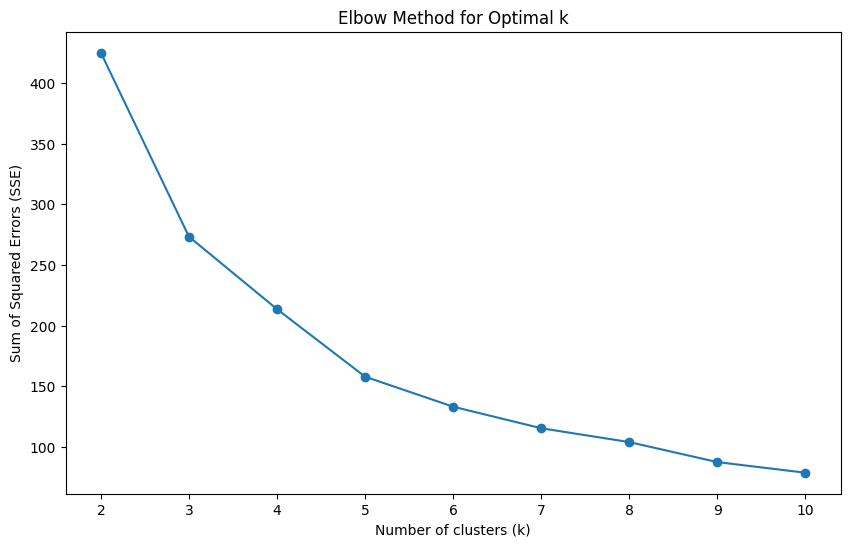

In [19]:
x = profiles_normalized.values

scaler = StandardScaler()
x_scaled = scaler .fit_transform(x)

sse = {}
for k in range(2,11):
    kMeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(x_scaled)
    sse[k] = kMeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [20]:
OPTIMAL_K = 5

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(x_scaled)

profiles_normalized['behavioral_cluster'] = clusters

print(f"\nSuccessfully segmented customers into {OPTIMAL_K} behavioral clusters.")


Successfully segmented customers into 5 behavioral clusters.


In [22]:
avg_profiles_df['behavioral_cluster'] = clusters

cluster_profile = avg_profiles_df.groupby('behavioral_cluster').mean()

cluster_profile

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
behavioral_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.041930,0.041043,0.041123,0.040931,0.040774,0.038700,0.013050,0.004360,0.002949,0.002648,...,0.002938,0.002839,0.003122,0.003712,0.029858,0.042778,0.044271,0.043830,0.043159,0.042600
1,0.106637,0.102044,0.098378,0.096093,0.097071,0.106050,0.086032,0.078857,0.076186,0.076776,...,0.095003,0.094823,0.093614,0.094960,0.122234,0.140419,0.141357,0.134055,0.121630,0.112838
2,0.000096,0.000003,0.000092,0.000003,0.000000,0.000370,0.001483,0.001536,0.003457,0.003489,...,0.001770,0.001942,0.001603,0.002459,0.002197,0.001174,0.000393,0.000286,0.000191,0.000188
3,0.044151,0.042374,0.041904,0.040813,0.044732,0.042172,0.023956,0.014657,0.011303,0.010192,...,0.014079,0.012671,0.012969,0.014795,0.038036,0.048938,0.052230,0.049896,0.048966,0.046467
4,0.001532,0.001238,0.001197,0.000715,0.000492,0.000434,0.000358,0.001106,0.007281,0.016515,...,0.000993,0.001152,0.001081,0.001047,0.001984,0.006131,0.005750,0.002625,0.001914,0.001446


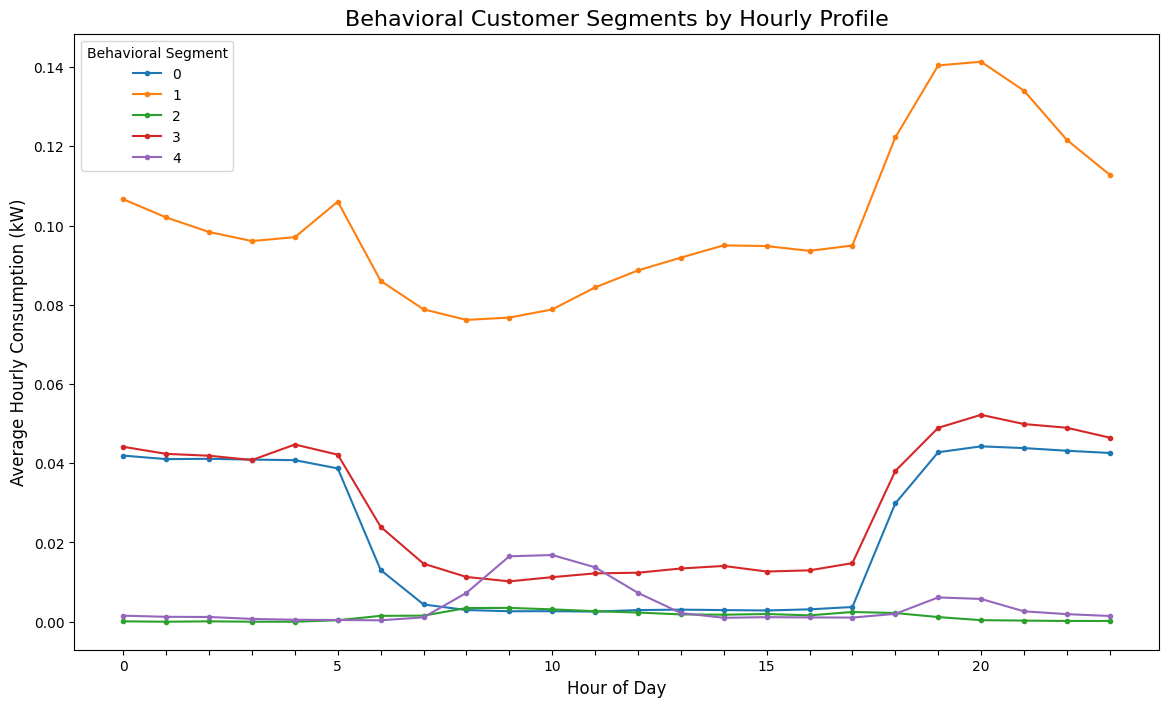

In [27]:
cluster_profile.T.plot(figsize=(14, 8), marker='.')

plt.title('Behavioral Customer Segments by Hourly Profile', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Hourly Consumption (kW)', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Behavioral Segment')
plt.show()